In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import datetime
from tqdm.notebook import tqdm
import quantstats as qs

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,8)

# 一、北上资金介绍
外资作为中国资本市场上的神秘力量，有诸多别称，“smart money”、聪明 钱、洋韭菜等，随着 A 股纳入 MSCI 指数、陆股通等渠道的开通，海外个人投资 者逐渐获得 A 股投资权限，投资便利性的增加使得 A 股市场投资者结构发生巨大 变化。

通常而言的“北上资金”和“南下资金”分别代指进入 A 股的香港国际资本 (即陆股通)和进入港股的中国内 地资本(通过港股通流 入港股的资金)。本文 将介绍北上资金进入中国的渠道和发展历程，并分析北上资金对沪市和深市当日 涨跌情况的影响力，最后分析北上资金对沪市和深市未来收益率的预测作用，给 出比较好的择时策略。


## 1. 沪/深股通累计资金流向

In [12]:
SH_HK = pd.read_excel("./data/沪港通成交统计(按市场).xlsx",header=1)
SH_HK = SH_HK[SH_HK.columns[[1,2,5,6]]].rename(columns={"Unnamed: 1":"time"}).set_index('time').iloc[:-2]
SH_HK

,期间合计买卖总额,成交净买入,累计净买入
time,,,
2023-04-28,736.2139,-7.8885,10043.1374
2023-04-27,669.4998,-5.1370,10051.0259
2023-04-26,685.1444,0.7902,10056.1629
2023-04-25,693.2821,-16.4373,10055.3727
2023-04-24,641.1537,2.0825,10071.8100
...,...,...,...
2019-01-08,93.9183,10.2061,3793.4367
2019-01-07,107.0618,9.4706,3783.2306
2019-01-04,129.9318,-4.9984,3773.7600


In [13]:
SZ_HK = pd.read_excel("./data/深港通成交统计(按市场).xlsx",header=1)
SZ_HK = SZ_HK[SZ_HK.columns[[1,2,5,6]]].rename(columns={"Unnamed: 1":"time"}).set_index('time').iloc[:-2]
SZ_HK

,期间合计买卖总额,成交净买入,累计净买入
time,,,
2023-04-28,741.8385,23.7423,9017.1878
2023-04-27,749.9757,3.4725,8993.4455
2023-04-26,836.2542,6.7228,8989.9730
2023-04-25,810.9781,-32.7349,8983.2502
2023-04-24,773.0141,-40.3597,9015.9851
...,...,...,...
2019-01-08,80.6950,3.9544,2668.2343
2019-01-07,89.0039,6.9929,2664.2799
2019-01-04,88.3764,7.3670,2657.2870


In [14]:
acc_buyin_equity = pd.merge(SH_HK['累计净买入'], SZ_HK['累计净买入'], left_index = True, right_index = True).rename(columns={'累计净买入_x':'SH_HK','累计净买入_y':'SZ_HK'})
acc_buyin_equity['sum'] = acc_buyin_equity['SH_HK'] + acc_buyin_equity['SZ_HK']
acc_buyin_equity

,SH_HK,SZ_HK,sum
time,,,
2023-04-28,10043.1374,9017.1878,19060.3252
2023-04-27,10051.0259,8993.4455,19044.4714
2023-04-26,10056.1629,8989.9730,19046.1359
2023-04-25,10055.3727,8983.2502,19038.6229
2023-04-24,10071.8100,9015.9851,19087.7951
...,...,...,...
2019-01-08,3793.4367,2668.2343,6461.6710
2019-01-07,3783.2306,2664.2799,6447.5105
2019-01-04,3773.7600,2657.2870,6431.0470


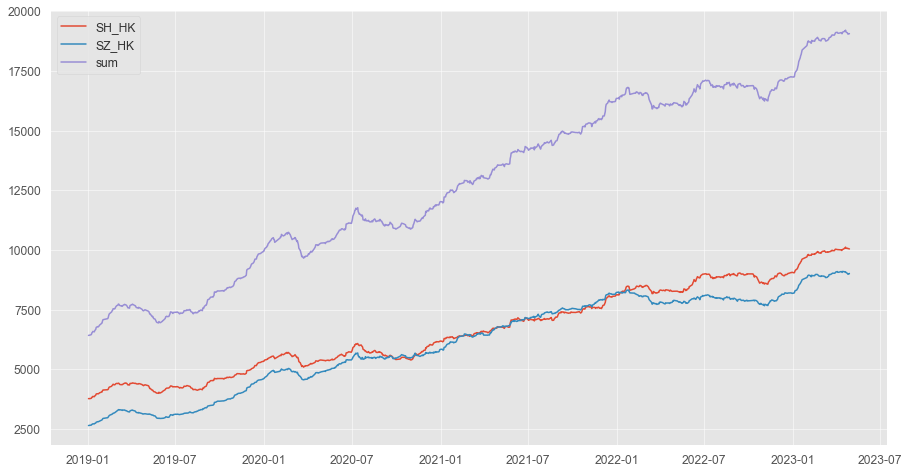

In [15]:
plt.plot(acc_buyin_equity, label=['SH_HK','SZ_HK','sum'])
plt.legend()

沪股通的投资者持股市值，占流通A股比逐年增加

In [36]:
cap_SH = pd.read_excel('./data/投资者持股市值_沪股通.xlsx', header=0).iloc[:-2].rename(columns={'指标名称':'time'}).set_index('time')
cap_SH.index = pd.to_datetime(cap_SH.index)
cap_SH

/Users/yuchen/opt/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,投资者持股市值:沪股通,投资者持股市值占比:沪股通
time,,
2014-12-31,865.0000,0.39
2015-12-31,1248.1681,0.49
2016-12-31,1711.2300,0.72
2017-12-31,3322.0000,1.18
2018-12-31,4437.0000,1.91
2019-12-31,8374.0000,2.79
2020-12-31,12659.0000,3.34
2021-12-31,14251.0000,3.28


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


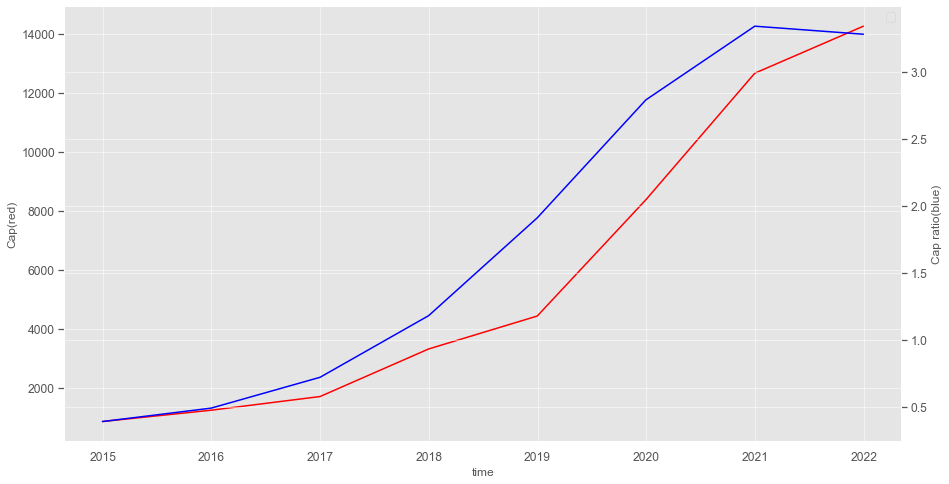

In [37]:
fig, ax = plt.subplots()
ax.plot(cap_SH.index, cap_SH['投资者持股市值:沪股通'],color='red')
ax.set_ylabel('Cap(red)')
ax.set_xlabel('time')
ax.spines['right'].set_visible(False) # ax右轴隐藏

z_ax = ax.twinx() # 创建与轴群ax共享x轴的轴群z_ax
z_ax.plot(cap_SH.index, cap_SH['投资者持股市值占比:沪股通'], color='blue')
z_ax.set_ylabel('Cap ratio(blue)')

plt.show()

In [39]:
# 单位：亿元
total_trade_volume = pd.merge(SH_HK['期间合计买卖总额'], SZ_HK['期间合计买卖总额'], left_index = True, right_index = True).rename(columns={'期间合计买卖总额_x':'SH_HK','期间合计买卖总额_y':'SZ_HK'})
total_trade_volume['sum'] = total_trade_volume['SH_HK'] + total_trade_volume['SZ_HK']
total_trade_volume

,SH_HK,SZ_HK,sum
time,,,
2023-04-28,736.2139,741.8385,1478.0524
2023-04-27,669.4998,749.9757,1419.4755
2023-04-26,685.1444,836.2542,1521.3986
2023-04-25,693.2821,810.9781,1504.2602
2023-04-24,641.1537,773.0141,1414.1678
...,...,...,...
2019-01-08,93.9183,80.6950,174.6133
2019-01-07,107.0618,89.0039,196.0657
2019-01-04,129.9318,88.3764,218.3082


In [40]:
total_trade_volume = total_trade_volume.dropna()
total_trade_volume

,SH_HK,SZ_HK,sum
time,,,
2023-04-28,736.2139,741.8385,1478.0524
2023-04-27,669.4998,749.9757,1419.4755
2023-04-26,685.1444,836.2542,1521.3986
2023-04-25,693.2821,810.9781,1504.2602
2023-04-24,641.1537,773.0141,1414.1678
...,...,...,...
2019-01-08,93.9183,80.6950,174.6133
2019-01-07,107.0618,89.0039,196.0657
2019-01-04,129.9318,88.3764,218.3082


北上资金每日成交额逐年增加

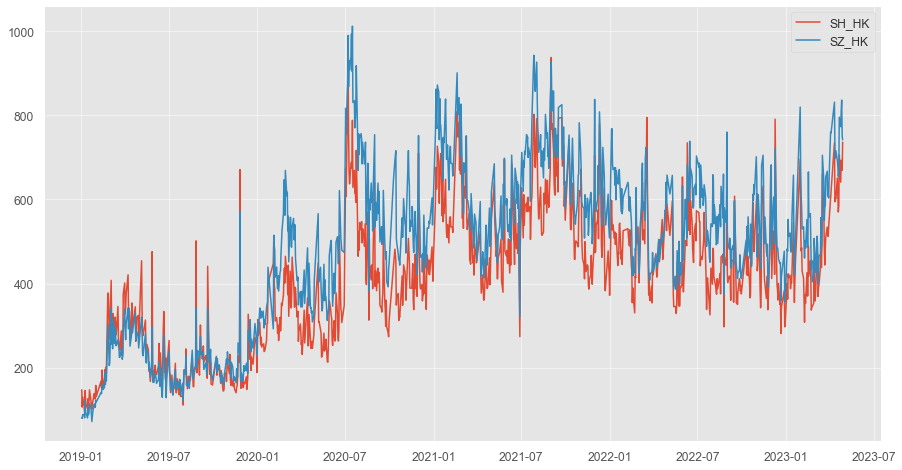

In [43]:
plt.plot(total_trade_volume.SH_HK, label='SH_HK')
plt.plot(total_trade_volume.SZ_HK, label='SZ_HK')
plt.legend()

In [44]:
SH_volume = pd.read_excel('./data/上证成交额.xlsx', header=1).rename(columns={'时间':'time', '上证指数':'volume'}).set_index('time').iloc[:-4]
SH_volume

,volume
time,
2019-01-02,975.9257
2019-01-03,1069.2279
2019-01-04,1392.9868
2019-01-07,1455.1324
2019-01-08,1233.7904
...,...
2023-04-24,4732.6599
2023-04-25,4942.4013
2023-04-26,4804.1815


In [45]:
SZ_volume = pd.read_excel('./data/深证成交额.xlsx', header=1).rename(columns={'时间':'time', '深证综指':'volume'}).set_index('time').iloc[:-4]
SZ_volume

,volume
time,
2019-01-02,1286.6999
2019-01-03,1452.3886
2019-01-04,1829.6232
2019-01-07,2017.8567
2019-01-08,1763.5651
...,...
2023-04-24,6100.6248
2023-04-25,6396.9350
2023-04-26,6418.0271


In [46]:
SZ_volume = SZ_volume.loc[total_trade_volume.index]
SH_volume = SH_volume.loc[total_trade_volume.index]
total_trade_volume['SH_ratio'] = total_trade_volume['SH_HK'] / SH_volume['volume']
total_trade_volume['SZ_ratio'] = total_trade_volume['SZ_HK'] / SZ_volume['volume']
total_trade_volume = total_trade_volume.sort_index()

/var/folders/g2/vhgnj1gx5bn1tn3pm6kyf1ym0000gn/T/ipykernel_86995/285220605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_trade_volume['SH_ratio'] = total_trade_volume['SH_HK'] / SH_volume['volume']
/var/folders/g2/vhgnj1gx5bn1tn3pm6kyf1ym0000gn/T/ipykernel_86995/285220605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_trade_volume['SZ_ratio'] = total_trade_volume['SZ_HK'] / SZ_volume['volume']


沪股通成交金额/上证成交金额

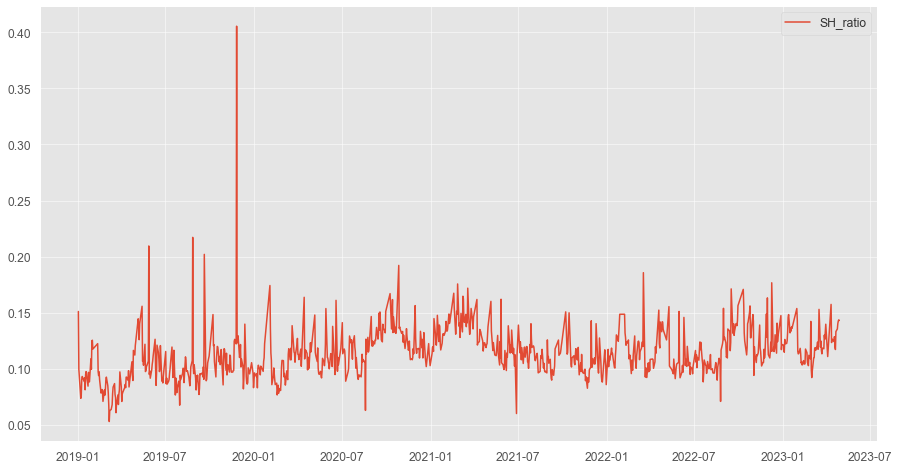

In [48]:
plt.plot(total_trade_volume[['SH_ratio']],label='SH_ratio')
plt.legend()

深股通成交金额/深证成交金额

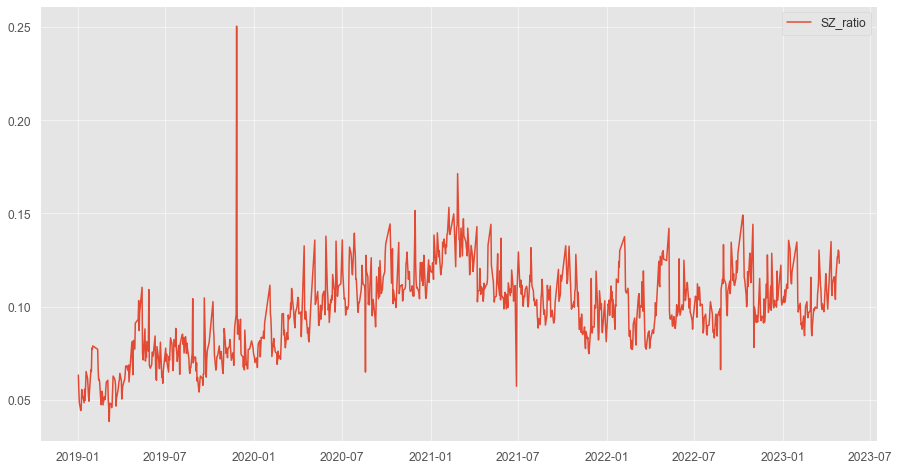

In [49]:
plt.plot(total_trade_volume[['SZ_ratio']],label='SZ_ratio')
plt.legend()

In [51]:
x = np.array([i for i in range(len(total_trade_volume.index))])
y_SH = total_trade_volume['SH_ratio'].values
y_SZ = total_trade_volume['SZ_ratio'].values
X = sm.add_constant(x)
model_SH = sm.OLS(y_SH, X)
model_SZ = sm.OLS(y_SZ, X)
fit_SH = model_SH.fit()
fit_SZ = model_SZ.fit()
fit_SH.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     97.44
Date:                Wed, 24 May 2023   Prob (F-statistic):           5.39e-22
Time:                        07:36:57   Log-Likelihood:                 2431.6
No. Observations:                1002   AIC:                            -4859.
Df Residuals:                    1000   BIC:                            -4849.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1017      0.001     75.274      0.000       0.099       0.104
x1          2.306e-05   2.34e-06      9.871      0.000    1.85e-05    2.77e-05
==============================================================================
Omnibus:                      860.350   Durbin-Watson:                   1.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65368.878
Skew:                           3.459   Prob(JB):                         0.00
Kurtosis:                      41.960   Cond. No.                     1.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
fit_SZ.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     356.0
Date:                Wed, 24 May 2023   Prob (F-statistic):           3.70e-68
Time:                        07:36:57   Log-Likelihood:                 2545.2
No. Observations:                1002   AIC:                            -5086.
Df Residuals:                    1000   BIC:                            -5077.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0779      0.001     64.618      0.000       0.076       0.080
x1          3.936e-05   2.09e-06     18.867      0.000    3.53e-05    4.35e-05
==============================================================================
Omnibus:                      256.786   Durbin-Watson:                   0.472
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1252.058
Skew:                           1.097   Prob(JB):                    1.32e-272
Kurtosis:                       8.017   Cond. No.                     1.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

北上资金在 A 股的活跃度不断提升，到目前为止， 沪股通成交金额占上证成交金额的比例基本维持 10%以上，深股通成交金额占深 证成交金额的比例基本维持在 8%以上。

总的来说，北上资金虽然占比只有 A 股流通总市值的 3%，但是其活跃程度 不容小觑，当前北上资金成交金额占比大约为 A 股总成交金额的 10%。北上资金 在 A 股的舞台上扮演着越来越重要的角色。

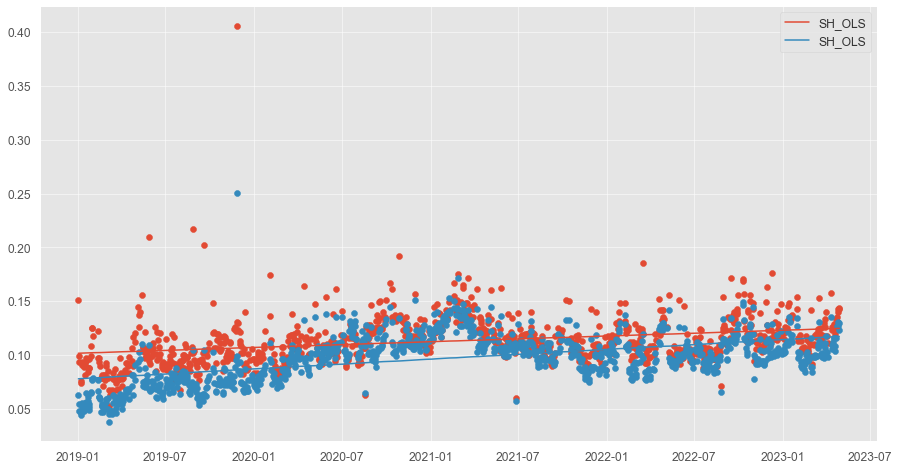

In [53]:
total_trade_volume['SH_OLS'] = fit_SH.predict(X)
total_trade_volume['SZ_OLS'] = fit_SZ.predict(X)
plt.scatter(total_trade_volume.index, total_trade_volume['SH_ratio'])
plt.plot(total_trade_volume['SH_OLS'],label='SH_OLS')
plt.scatter(total_trade_volume.index, total_trade_volume['SZ_ratio'])
plt.plot(total_trade_volume['SZ_OLS'],label='SH_OLS')
plt.legend()

## 2. 北上资金和沪、深两市涨跌的相关性
以当日沪/深股通净流入为自变量，以当日上证综指/深证成指收盘价 涨跌幅为因变量进行回归，回归的时间选择为过去一年的数据。原因 在于北上资金的行为受政策、汇率等因素影响较大，在不同时间点，北上资金和 沪深两市的相关行可能表现出不同特点，所以本文中取一年为时间窗口进行回归。

In [54]:
SH_udratio = pd.read_excel('./data/上证指数收盘涨跌幅.xlsx', header=1).rename(columns={'时间':'time', '上证指数':'SH'}).set_index('time').iloc[:-4]
SZ_udratio = pd.read_excel('./data/深证指数收盘涨跌幅.xlsx', header=1).rename(columns={'时间':'time', '深证综指':'SZ'}).set_index('time').iloc[:-4]
udratio = pd.merge(SH_udratio, SZ_udratio, left_index=True, right_index=True)
udratio = udratio.loc[total_trade_volume.index]
udratio

,SH,SZ
time,,
2019-01-02,-1.1470,-0.9054
2019-01-03,-0.0377,-0.7979
2019-01-04,2.0494,2.6576
2019-01-07,0.7245,1.7130
2019-01-08,-0.2616,-0.1166
...,...,...
2023-04-24,-0.7829,-0.8186
2023-04-25,-0.3218,-1.6892
2023-04-26,-0.0236,0.5212


In [55]:
net_buyin = pd.merge(SH_HK['成交净买入'], SZ_HK['成交净买入'], left_index = True, right_index = True).rename(columns={'成交净买入_x':'SH_HK','成交净买入_y':'SZ_HK'})
net_buyin = net_buyin.loc[total_trade_volume.index]
net_buyin

,SH_HK,SZ_HK
time,,
2019-01-02,5.9221,-2.3834
2019-01-03,6.0612,1.7400
2019-01-04,-4.9984,7.3670
2019-01-07,9.4706,6.9929
2019-01-08,10.2061,3.9544
...,...,...
2023-04-24,2.0825,-40.3597
2023-04-25,-16.4373,-32.7349
2023-04-26,0.7902,6.7228


In [56]:
tvalues_SH = []
rsquared_SH = []

for i,end_index in tqdm(enumerate(net_buyin.loc[datetime.datetime(2020,1,1):].index)):
    start_index = net_buyin.index[i]
    x = net_buyin.SH_HK.loc[start_index : end_index]
    y = udratio.SH.loc[start_index : end_index]
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    fit = model.fit()
    tvalues_SH.append(fit.tvalues.SH_HK)
    rsquared_SH.append(fit.rsquared_adj)

0it [00:00, ?it/s]

回归结果能反应北上资金净流入和对上证综指涨跌的相关关系。拟合优度越 大，T 值越显著，说明相关性越高。

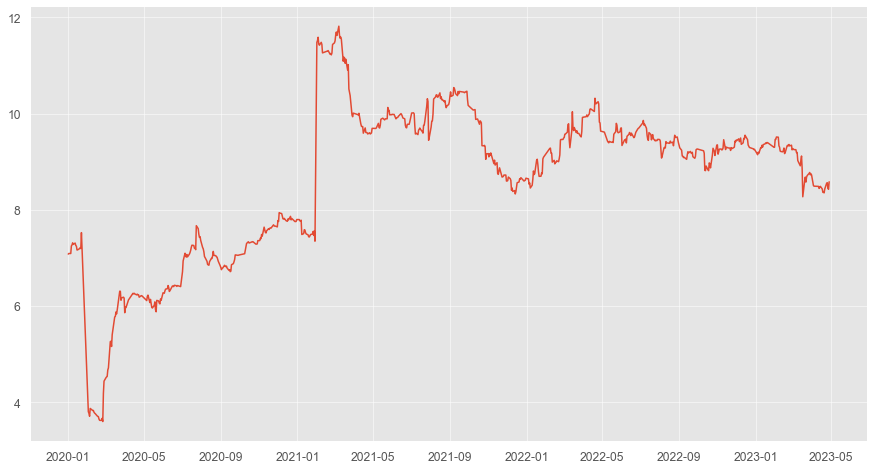

In [61]:
fig, ax = plt.subplots()
ax.plot(net_buyin.loc[datetime.datetime(2020,1,1):].index, tvalues_SH)

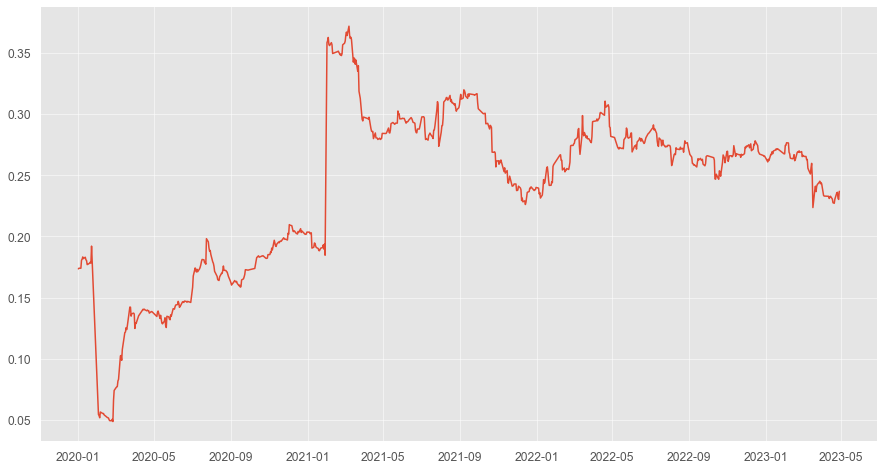

In [62]:
fig, ax = plt.subplots()
ax.plot(net_buyin.loc[datetime.datetime(2020,1,1):].index, rsquared_SH)

从图中可以看出，沪股通净流入对上证综指当日涨跌幅的解释度总 体呈上升趋势，从 T 值来看，从 2020 年 1月 1 号开始，该指标一直为显著(t > 1.96)。总的来说，沪股通净流入与上证综指当日涨跌相关性明显，且逐年上升。

In [63]:
tvalues_SZ = []
rsquared_SZ = []

for i,end_index in tqdm(enumerate(net_buyin.loc[datetime.datetime(2020,1,1):].index)):
    start_index = net_buyin.index[i]
    x = net_buyin.SZ_HK.loc[start_index : end_index]
    y = udratio.SZ.loc[start_index : end_index]
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    fit = model.fit()
    tvalues_SZ.append(fit.tvalues.SZ_HK)
    rsquared_SZ.append(fit.rsquared_adj)

0it [00:00, ?it/s]

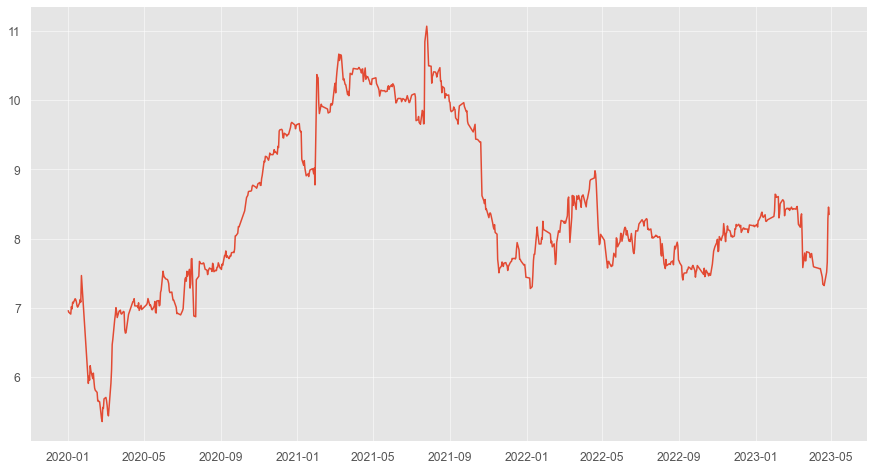

In [64]:
fig, ax = plt.subplots()
ax.plot(net_buyin.loc[datetime.datetime(2020,1,1):].index, tvalues_SZ)

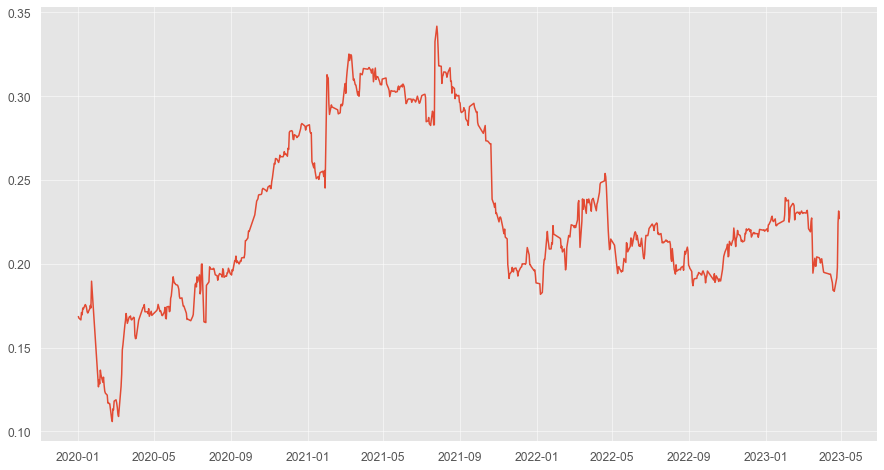

In [65]:
fig, ax = plt.subplots()
ax.plot(net_buyin.loc[datetime.datetime(2020,1,1):].index, rsquared_SZ)

# 3. 北上资金的择时效果
以沪股通为例，讨论其净流入对上证指数的择时效果。

用沪股通当日净流入为自变量，上证 综指未来一天的收益率为因变量进行回归。

In [66]:
close_SH = pd.read_excel('./data/上证收盘价.xlsx', header=1).rename(columns={'时间':'time', '上证指数':'SH'}).set_index('time').iloc[:-4]
close_SH = close_SH.loc[total_trade_volume.index]
close_SH.index = pd.to_datetime(close_SH.index)
close_SH

,SH
time,
2019-01-02,2465.2910
2019-01-03,2464.3628
2019-01-04,2514.8682
2019-01-07,2533.0887
2019-01-08,2526.4622
...,...
2023-04-24,3275.4130
2023-04-25,3264.8717
2023-04-26,3264.1006


In [67]:
ret_SH = np.log(close_SH.SH.values[1:]) - np.log(close_SH.SH.values[:-1])
ret_close_SH = pd.DataFrame(index=close_SH.index[1:])
ret_close_SH['SH'] = ret_SH
ret_close_SH

,SH
time,
2019-01-03,-0.000377
2019-01-04,0.020287
2019-01-07,0.007219
2019-01-08,-0.002619
2019-01-09,0.007053
...,...
2023-04-24,-0.007859
2023-04-25,-0.003224
2023-04-26,-0.000236


In [68]:
x = net_buyin.SH_HK[:-1].values
y = ret_close_SH.SH.values
X = sm.add_constant(x)
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.058
Date:                Wed, 24 May 2023   Prob (F-statistic):             0.0442
Time:                        08:37:23   Log-Likelihood:                 3075.5
No. Observations:                1001   AIC:                            -6147.
Df Residuals:                     999   BIC:                            -6137.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.425      0.671      -0.001       0.001
x1          2.303e-05   1.14e-05      2.014      0.044    5.95e-07    4.55e-05
==============================================================================
Omnibus:                      168.060   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1217.387
Skew:                          -0.552   Prob(JB):                    4.44e-265
Kurtosis:                       8.289   Cond. No.                         32.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

从回归结果来看，沪股通当日净流入对上证综指未来一天收益率确实存在一 定影响(t 值在 97.5%置信水平上显著)。

In [69]:
open_SH = pd.read_excel('./data/上证开盘价.xlsx', header=1).rename(columns={'时间':'time', '上证指数':'SH'}).set_index('time').iloc[:-4]
open_SH = open_SH.loc[total_trade_volume.index]
open_SH.index = pd.to_datetime(open_SH.index)
open_SH

,SH
time,
2019-01-02,2497.8805
2019-01-03,2461.7829
2019-01-04,2446.0193
2019-01-07,2528.6987
2019-01-08,2530.3001
...,...
2023-04-24,3300.8125
2023-04-25,3276.4030
2023-04-26,3255.2171


In [70]:
ret_SH = np.log(open_SH.SH.values[1:]) - np.log(open_SH.SH.values[:-1])
ret_open_SH = pd.DataFrame(index=open_SH.index[2:])
ret_open_SH['SH'] = ret_SH[1:]
ret_open_SH

,SH
time,
2019-01-04,-0.006424
2019-01-07,0.033243
2019-01-08,0.000633
2019-01-09,0.002415
2019-01-10,0.002927
...,...
2023-04-24,-0.018962
2023-04-25,-0.007422
2023-04-26,-0.006487


根据沪股通每日净流入数值的 1/4 分位数将其分为四组，分别记为负 情绪、低情绪、中情绪、高情绪。

择时策略回测结果

本节中给出两个不同的回测方案:

1、 在中、高情绪日之后，持仓上证综指一日(次日开盘价买入，后日开盘 价卖出);在负、低情绪日之后，做空上证综指一日。不考虑交易成本。

2、 在中、高情绪日之后，持仓上证综指一日(当日收盘价买入，明日收盘 价卖出);在负、低情绪日之后，做空上证综指一日。不考虑交易成本。

本节中的情绪分组采用观测日之 前过去日期沪股通净流 入的数据进行分组， 避免使用未来数据。多头组合指在负、低情绪日之后不对上证综指做空，选择空 仓的组合。

In [71]:
def mood_class(net_buyin_SH, x):
    q1 = np.percentile(net_buyin_SH, 25)
    q2 = np.percentile(net_buyin_SH, 50)
    q3 = np.percentile(net_buyin_SH, 75)
    if x <= q1:
        return 'mood1'
    elif x<= q2:
        return 'mood2'
    elif x<= q3:
        return 'mood3'
    else:
        return 'mood4'

In [72]:
ret_long_open = []
ret_longshort_open = []

for i,date in tqdm(enumerate(net_buyin.index[:-2])):
    day_index = net_buyin.index[i+2]
    net_buyin_SH = net_buyin.SH_HK.loc[:date]
    mood = mood_class(net_buyin_SH, net_buyin_SH.loc[date])
    if (mood == 'mood1') | (mood == 'mood2'):
        ret_long_open.append(0)
        ret_longshort_open.append(-ret_open_SH.SH.loc[day_index])

    elif (mood == 'mood3') | (mood == 'mood4'):
        ret_long_open.append(ret_open_SH.SH.loc[day_index])
        ret_longshort_open.append(ret_open_SH.SH.loc[day_index])


0it [00:00, ?it/s]

In [74]:
ret_long_close = []
ret_longshort_close = []

for i,date in tqdm(enumerate(net_buyin.index[:-2])):
    day_index = net_buyin.index[i+1]
    net_buyin_SH = net_buyin.SH_HK.loc[:date]
    mood = mood_class(net_buyin_SH, net_buyin_SH.loc[date])
    if (mood == 'mood1') | (mood == 'mood2'):
        ret_long_close.append(0)
        ret_longshort_close.append(-ret_close_SH.SH.loc[day_index])

    elif (mood == 'mood3') | (mood == 'mood4'):
        ret_long_close.append(ret_close_SH.SH.loc[day_index])
        ret_longshort_close.append(ret_close_SH.SH.loc[day_index])


0it [00:00, ?it/s]

In [75]:
ret_close = pd.DataFrame(index=close_SH.index[:-2])
ret_close['long'] = np.array(ret_long_close)
ret_close['longshort'] = np.array(ret_longshort_close)
ret_close

,long,longshort
time,,
2019-01-02,0.000000,0.000377
2019-01-03,0.020287,0.020287
2019-01-04,0.000000,-0.007219
2019-01-07,-0.002619,-0.002619
2019-01-08,0.007053,0.007053
...,...,...
2023-04-20,-0.019728,-0.019728
2023-04-21,0.000000,0.007859
2023-04-24,0.000000,0.003224


In [76]:
ret_open = pd.DataFrame(index=open_SH.index[:-2])
ret_open['long'] = np.array(ret_long_open)
ret_open['longshort'] = np.array(ret_longshort_open)
ret_open

,long,longshort
time,,
2019-01-02,0.000000,0.006424
2019-01-03,0.033243,0.033243
2019-01-04,0.000000,-0.000633
2019-01-07,0.002415,0.002415
2019-01-08,0.002927,0.002927
...,...,...
2023-04-20,-0.018962,-0.018962
2023-04-21,0.000000,0.007422
2023-04-24,0.000000,0.006487


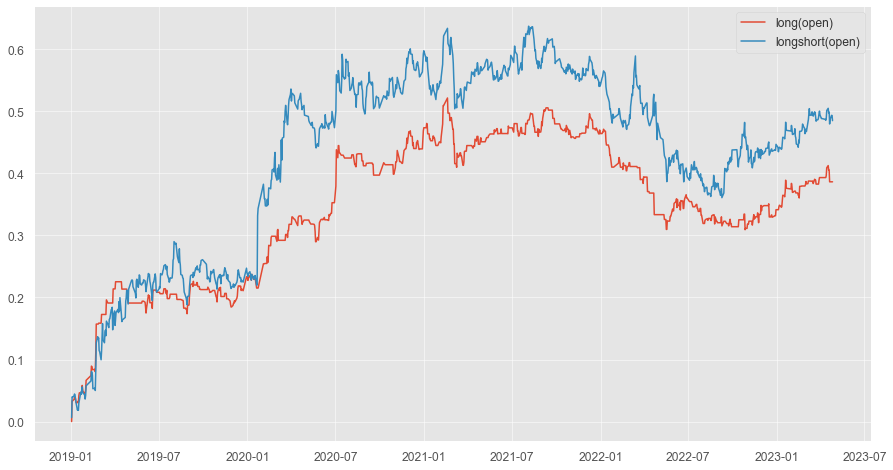

In [77]:
plt.plot(np.cumsum(ret_open.long), label='long(open)')
plt.plot(np.cumsum(ret_open.longshort), label='longshort(open)')
plt.legend()

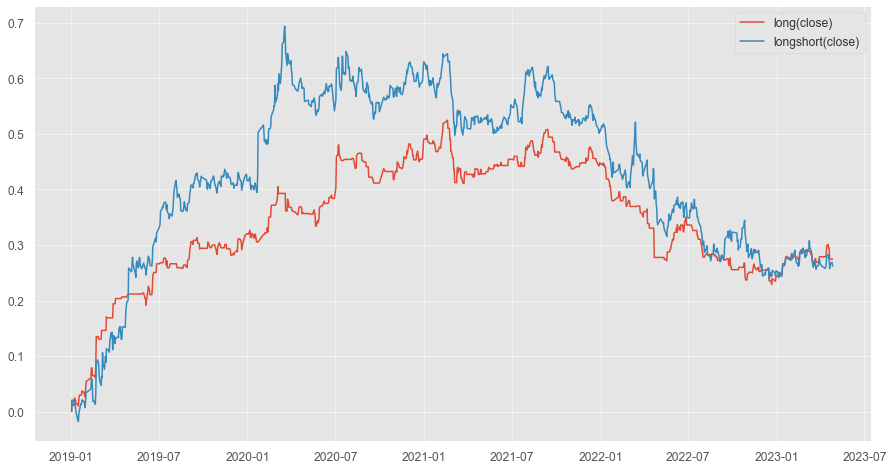

In [78]:
plt.plot(np.cumsum(ret_close.long), label='long(close)')
plt.plot(np.cumsum(ret_close.longshort), label='longshort(close)')
plt.legend()

In [80]:
net_value_open = pd.DataFrame(index=open_SH.index[4:-2])
net_value_close = pd.DataFrame(index=close_SH.index[4:-2])
net_value_open['long'] = 1
net_value_open['longshort'] = 1
net_value_close['long'] = 1
net_value_close['longshort'] = 1

for i in range(len(net_value_open)-1):
    net_value_open['long'].iloc[i+1] = net_value_open['long'].iloc[i] * (ret_long_open[i] + 1)
    net_value_open['longshort'].iloc[i+1] = net_value_open['longshort'].iloc[i] * (ret_longshort_open[i] + 1)
    net_value_close['long'].iloc[i+1] = net_value_close['long'].iloc[i] * (ret_long_close[i] + 1)
    net_value_close['longshort'].iloc[i+1] = net_value_close['longshort'].iloc[i] * (ret_longshort_close[i] + 1)


/var/folders/g2/vhgnj1gx5bn1tn3pm6kyf1ym0000gn/T/ipykernel_86995/2545473682.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  net_value_open['long'].iloc[i+1] = net_value_open['long'].iloc[i] * (ret_long_open[i] + 1)
/var/folders/g2/vhgnj1gx5bn1tn3pm6kyf1ym0000gn/T/ipykernel_86995/2545473682.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  net_value_close['long'].iloc[i+1] = net_value_close['long'].iloc[i] * (ret_long_close[i] + 1)


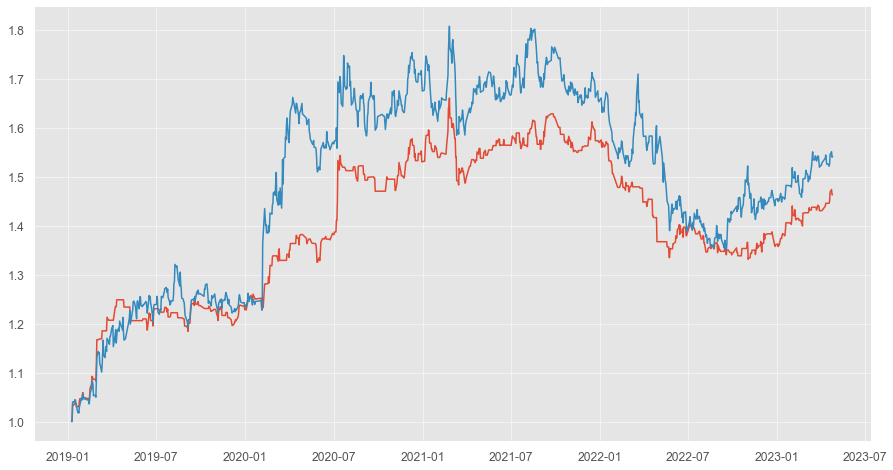

In [81]:
plt.plot(net_value_open)

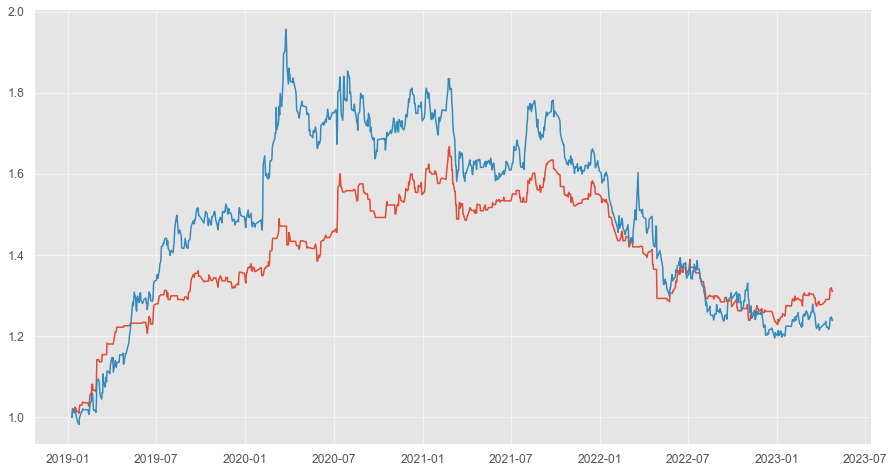

In [82]:
plt.plot(net_value_close)


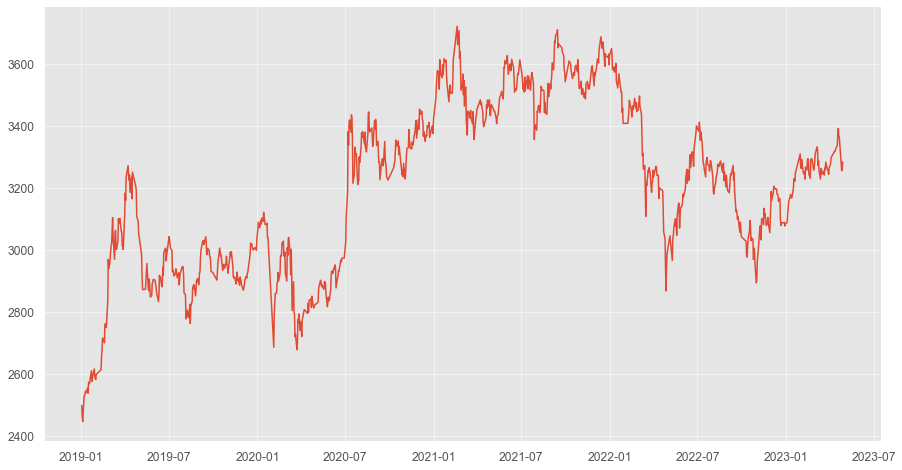

In [83]:
plt.plot(open_SH)

![jupyter](./matrix.jpeg)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2019-01-02  2019-01-02
End Period                 2023-04-26  2023-04-26
Risk-Free Rate             0.0%        0.0%
Time in Market             50.0%       100.0%

Cumulative Return          43.58%      24.44%
CAGR﹪                     8.75%       5.2%

Sharpe                     0.87        0.39
Prob. Sharpe Ratio         96.23%      78.05%
Smart Sharpe               0.86        0.39
Sortino                    1.39        0.54
Smart Sortino              1.38        0.54
Sortino/√2                 0.98        0.38
Smart Sortino/√2           0.98        0.38
Omega                      1.24        1.24

Max Drawdown               -19.83%     -24.04%
Longest DD Days            796         796
Volatility (ann.)          11.2%       18.33%
R^2                        0.0         0.0
Information Ratio          0.01        0.01
Calmar                     0.44        0.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-02-19,2022-10-27,2023-04-26,796,-19.832304,-19.291052
2,2019-04-16,2019-08-29,2019-12-30,258,-5.160931,-4.487044
3,2020-07-09,2020-09-18,2020-11-26,140,-4.713293,-4.607686
4,2020-04-22,2020-05-21,2020-06-18,57,-4.098504,-3.840586
5,2021-01-07,2021-01-25,2021-02-09,33,-3.524860,-3.103769


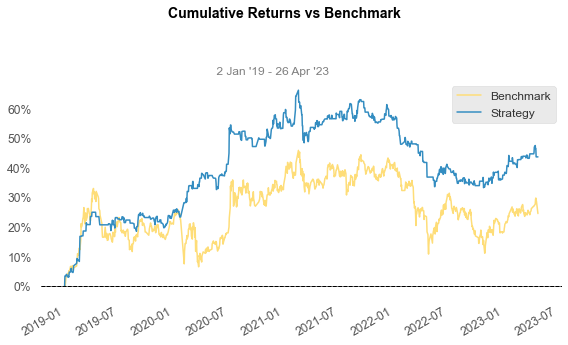

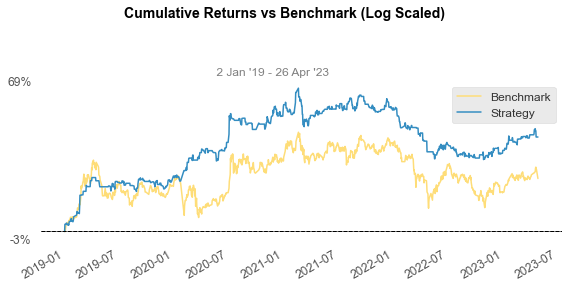

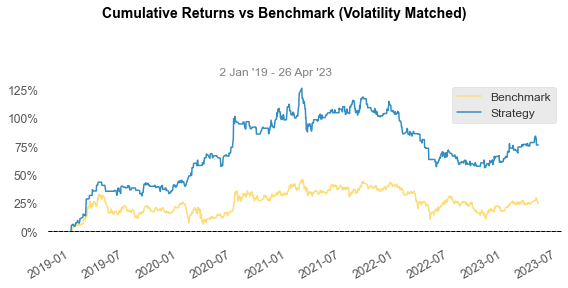

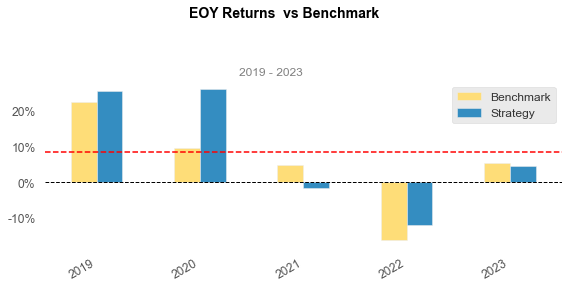

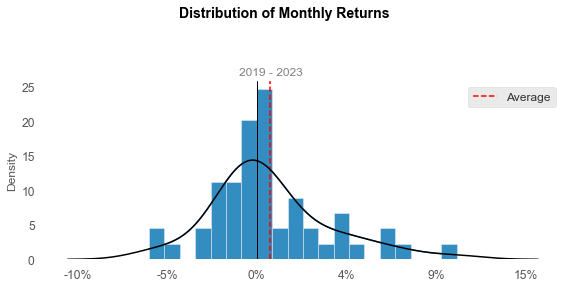

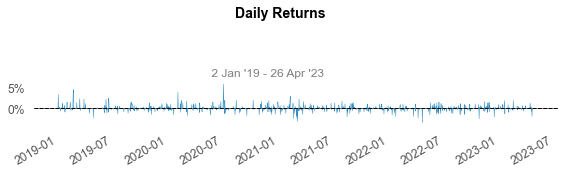

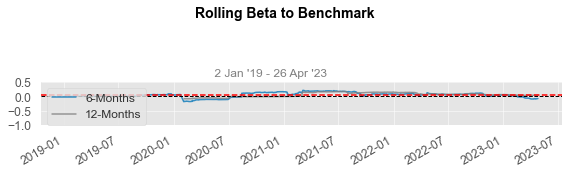

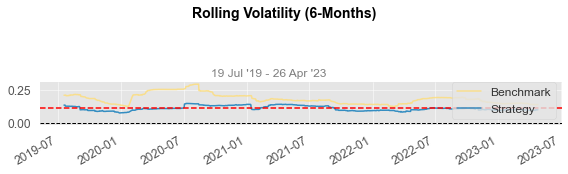

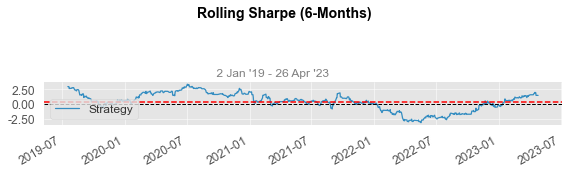

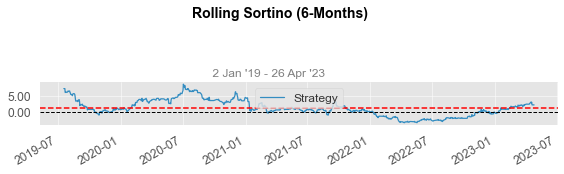

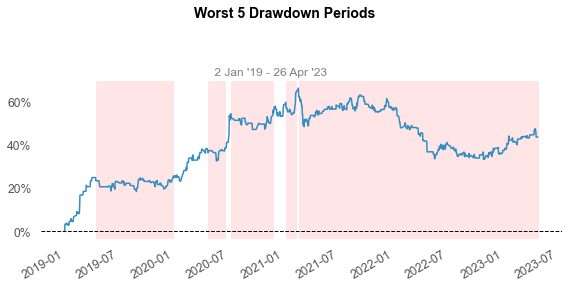

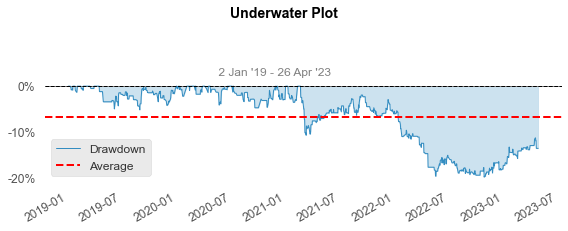

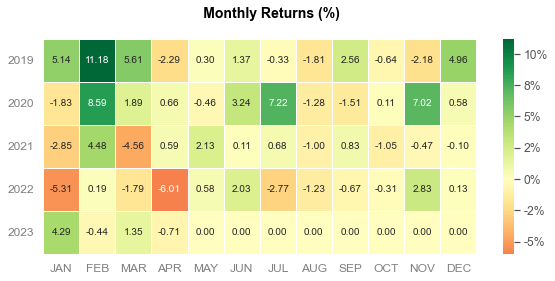

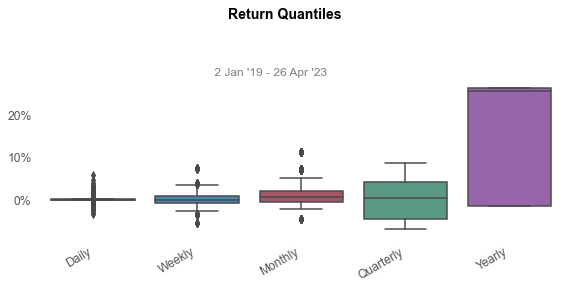

In [84]:
qs.reports.full(ret_open.long, benchmark=ret_open_SH)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2019-01-02  2019-01-02
End Period                 2023-04-26  2023-04-26
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          52.06%      24.44%
CAGR﹪                     10.2%       5.2%

Sharpe                     0.67        0.39
Prob. Sharpe Ratio         91.3%       78.05%
Smart Sharpe               0.65        0.39
Sortino                    1.06        0.54
Smart Sortino              1.04        0.53
Sortino/√2                 0.75        0.38
Smart Sortino/√2           0.74        0.38
Omega                      1.12        1.12

Max Drawdown               -25.31%     -24.04%
Longest DD Days            796         796
Volatility (ann.)          18.33%      18.33%
R^2                        0.0         0.0
Information Ratio          0.01        0.01
Calmar                     0.4         0.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-02-19,2022-09-09,2023-04-26,796,-25.310714,-24.774336
2,2019-08-05,2019-08-29,2020-01-22,170,-9.759347,-8.760199
3,2020-07-16,2020-08-31,2020-12-02,139,-9.414514,-8.978147
4,2020-04-01,2020-05-22,2020-07-03,93,-9.160948,-8.916645
5,2020-12-04,2021-01-25,2021-02-09,67,-8.002624,-7.307015


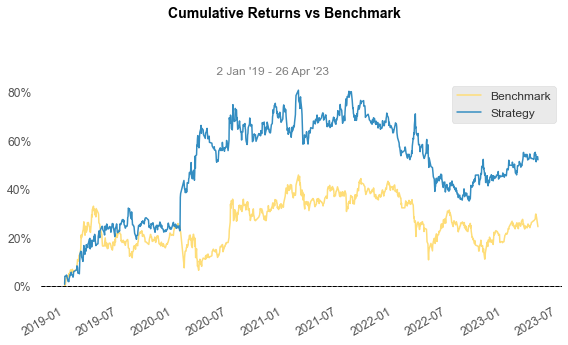

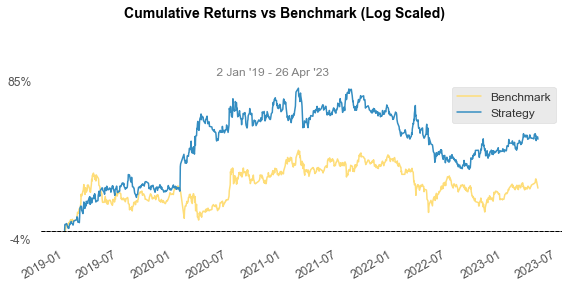

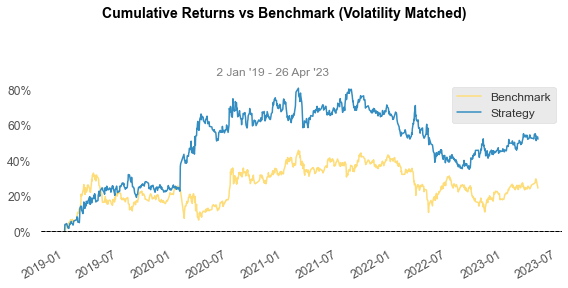

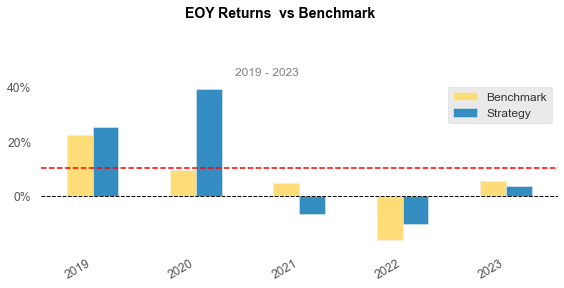

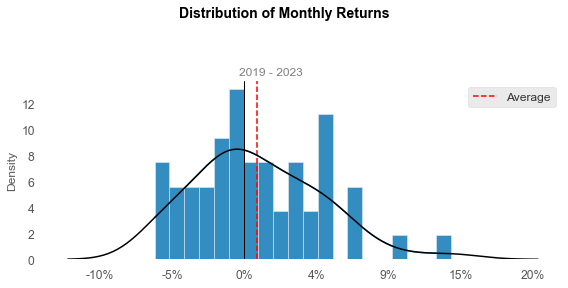

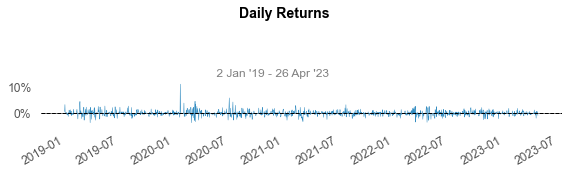

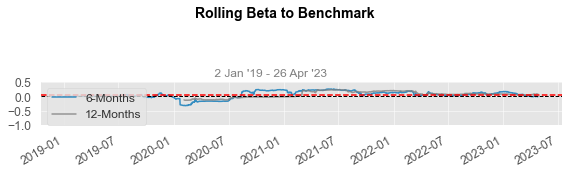

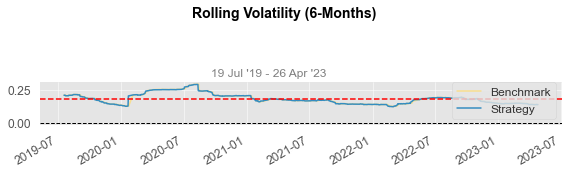

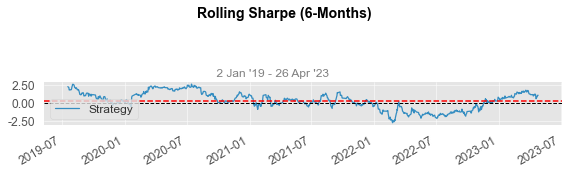

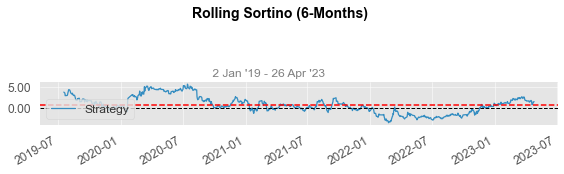

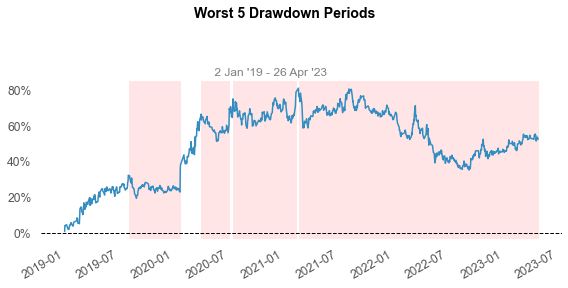

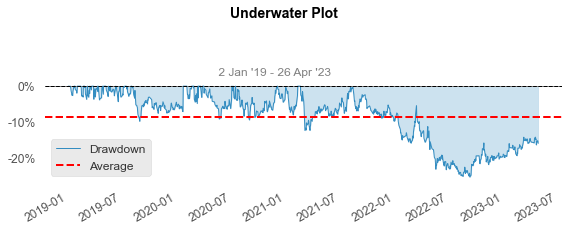

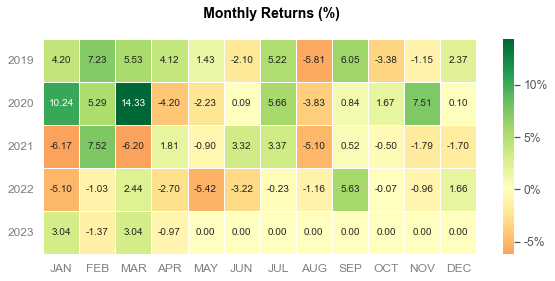

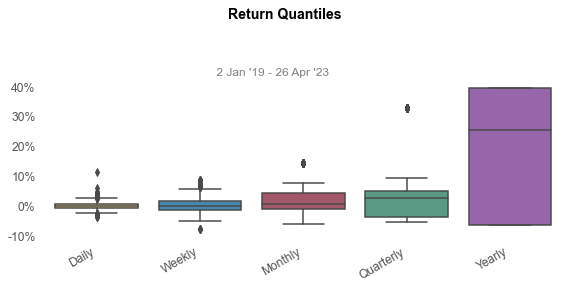

In [114]:
qs.reports.full(ret_open.longshort, benchmark=ret_open_SH)


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2019-01-02  2019-01-02
End Period                 2023-04-26  2023-04-26
Risk-Free Rate             0.0%        0.0%
Time in Market             50.0%       100.0%

Cumulative Return          28.42%      24.32%
CAGR﹪                     5.97%       5.17%

Sharpe                     0.62        0.4
Prob. Sharpe Ratio         89.43%      78.37%
Smart Sharpe               0.59        0.38
Sortino                    0.95        0.55
Smart Sortino              0.9         0.52
Sortino/√2                 0.67        0.39
Smart Sortino/√2           0.64        0.37
Omega                      1.17        1.17

Max Drawdown               -26.33%     -23.37%
Longest DD Days            796         793
Volatility (ann.)          11.13%      17.83%
R^2                        0.0         0.0
Information Ratio          -0.0        -0.0
Calmar                     0.23        0.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-02-19,2022-12-21,2023-04-26,796,-26.329426,-25.688505
2,2020-03-05,2020-05-21,2020-07-03,120,-7.006284,-6.390046
3,2020-07-09,2020-09-18,2020-12-31,175,-6.713365,-6.200335
4,2019-09-20,2019-11-28,2019-12-27,98,-3.139070,-3.062031
5,2021-01-07,2021-01-25,2021-02-08,32,-2.947338,-2.318662


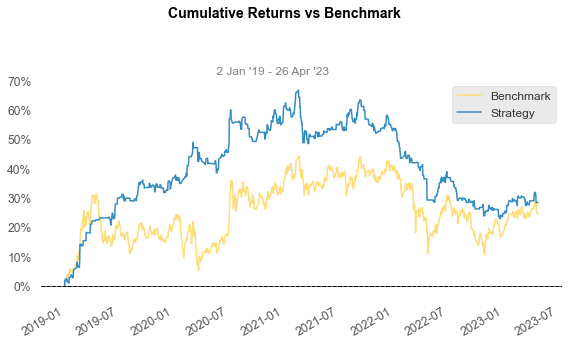

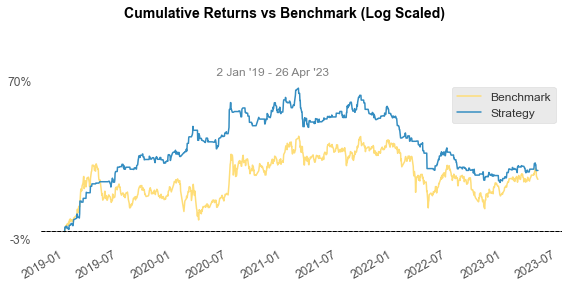

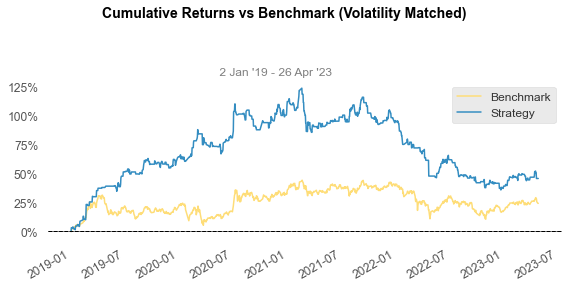

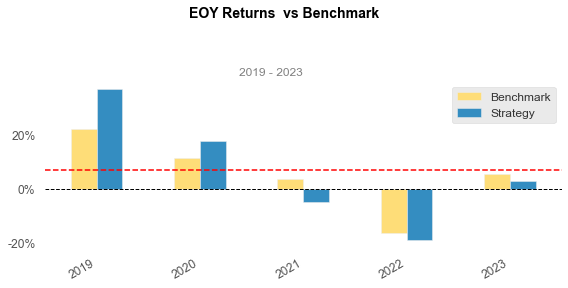

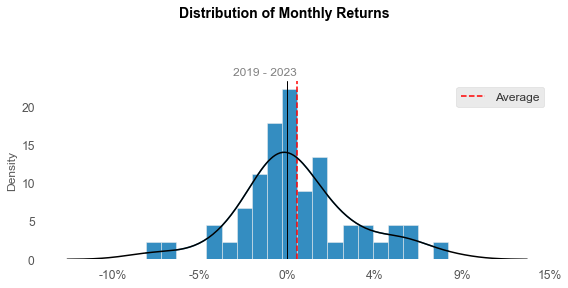

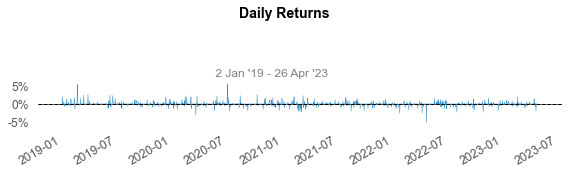

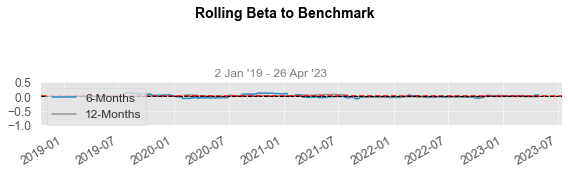

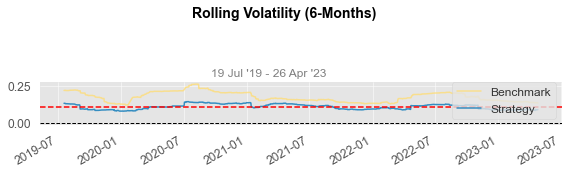

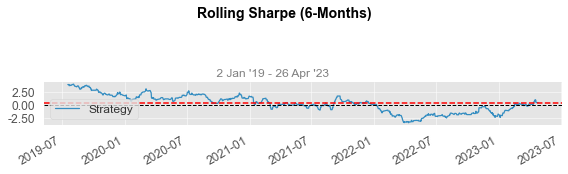

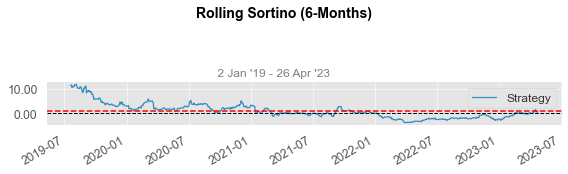

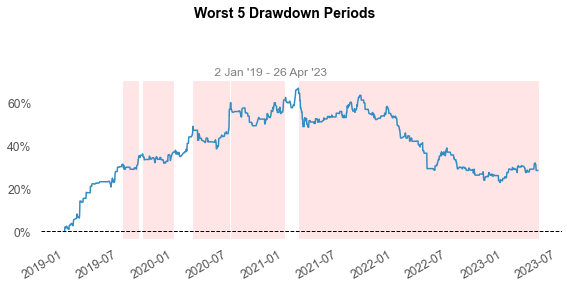

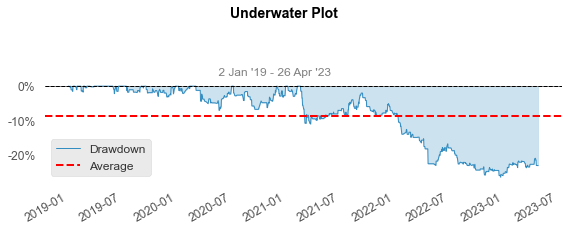

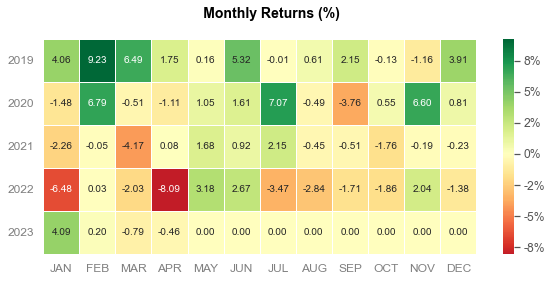

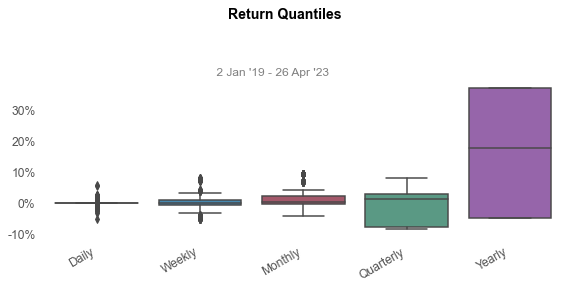

In [86]:
qs.reports.full(ret_close.long, benchmark=ret_close_SH)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2019-01-02  2019-01-02
End Period                 2023-04-26  2023-04-26
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          22.05%      24.32%
CAGR﹪                     4.73%       5.17%

Sharpe                     0.37        0.4
Prob. Sharpe Ratio         77.15%      78.37%
Smart Sharpe               0.35        0.37
Sortino                    0.57        0.55
Smart Sortino              0.54        0.52
Sortino/√2                 0.4         0.39
Smart Sortino/√2           0.38        0.36
Omega                      1.07        1.07

Max Drawdown               -38.91%     -23.37%
Longest DD Days            1133        793
Volatility (ann.)          17.83%      17.83%
R^2                        0.0         0.0
Information Ratio          -0.0        -0.0
Calmar                     0.12        0.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-19,2022-12-16,2023-04-26,1133,-38.909121,-38.535355
2,2019-08-07,2019-08-20,2019-09-16,40,-5.477419,-5.466604
3,2019-02-26,2019-03-04,2019-03-07,9,-4.555242,-3.710706
4,2019-02-13,2019-02-20,2019-02-22,9,-4.517383,-4.190045
5,2019-11-18,2020-01-21,2020-01-23,66,-4.213236,-3.942561


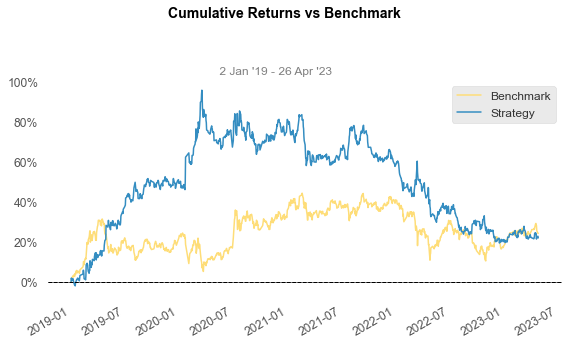

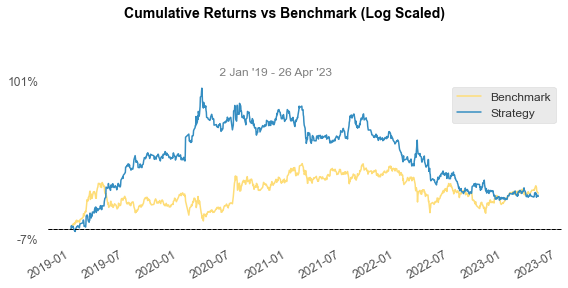

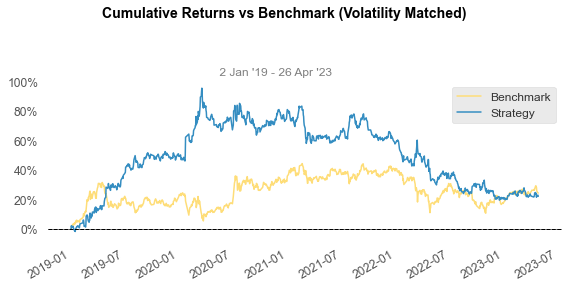

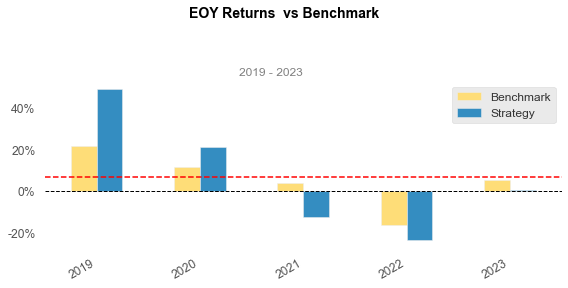

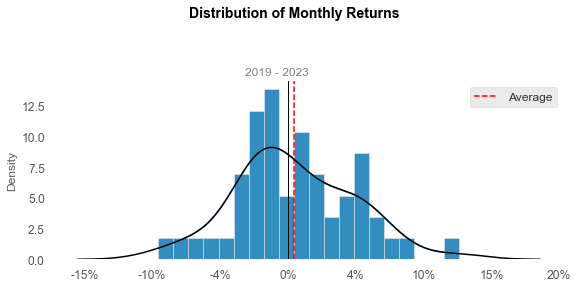

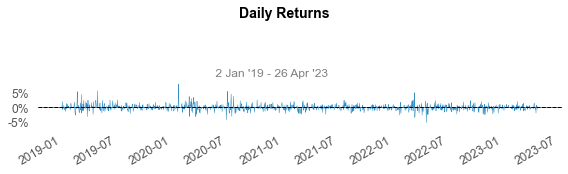

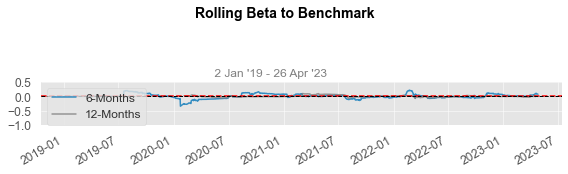

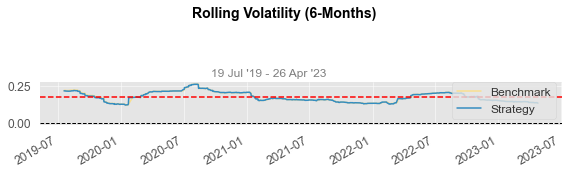

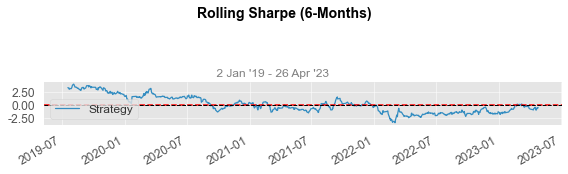

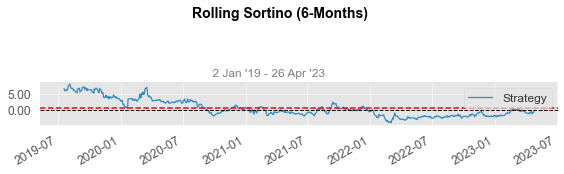

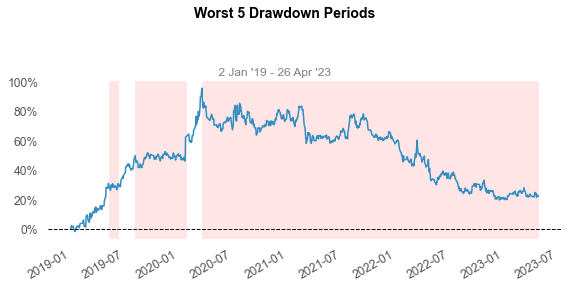

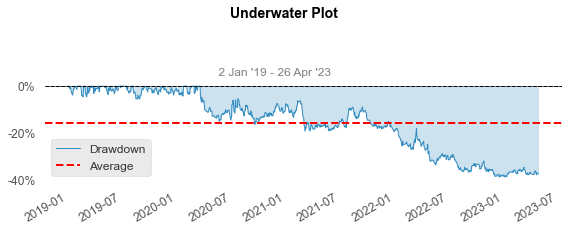

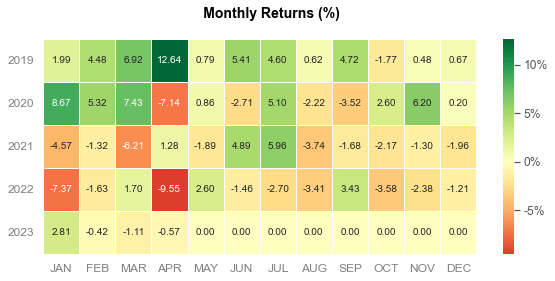

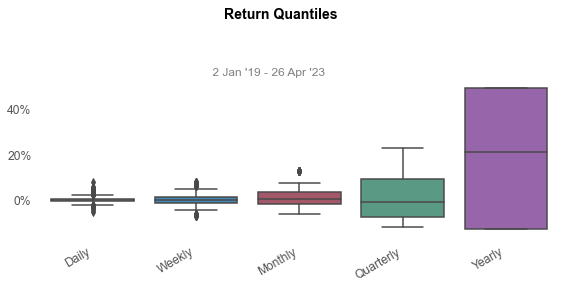

In [87]:
qs.reports.full(ret_close.longshort, benchmark=ret_close_SH)

In [93]:
print(qs.stats.win_rate(ret_open_SH.SH))
print(qs.stats.win_rate(ret_open.long))
print(qs.stats.win_rate(ret_open.longshort))
print(qs.stats.win_rate(ret_close_SH.SH))
print(qs.stats.win_rate(ret_close.long))
print(qs.stats.win_rate(ret_close.longshort))


0.522
0.5233265720081136
0.501
0.5214785214785215
0.5091277890466531
0.488
